# MSDS 7331 - Project 1 - Visualization
## Team: Dineen Parker, Dale Legband, Ryan Shuhart

In [9]:
### Modules Used ###

# Pandas Module for data manipulation
import pandas as pd

# pandas_profiling is a handy tool for inspecting data
# https://github.com/JosPolfliet/pandas-profiling
# pip install pandas-profiling
import pandas_profiling

# seaborn and matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Page settings - might not need...
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# Business Understanding (10 points total).
* Describe the purpose of the data set you selected (i.e., why was this data collected in
the first place?). 
* Describe how you would define and measure the outcomes from the
dataset. That is, why is this data important and how do you know if you have mined
useful knowledge from the dataset? 
* How would you measure the effectiveness of a
good prediction algorithm? Be specific.

From CRISP-DM article (https://mineracaodedados.files.wordpress.com/2012/04/the-crisp-dm-model-the-new-blueprint-for-data-mining-shearer-colin.pdf):
* What are the measures of success?
* Are there any assumptions?
* Create a glossary, if needed

# Data Understanding (80 points total)

* [15 points] Verify data quality: Explain any missing values, duplicate data, and outliers.
Are those mistakes? How do you deal with these problems? Give justifications for your
methods.

* [10 points] Visualize appropriate statistics (e.g., range, mode, mean, median, variance,
counts) for a subset of attributes. Describe anything meaningful you found from this or if
you found something potentially interesting. Note: You can also use data from other
sources for comparison. Explain why the statistics run are meaningful.

* [15 points] Visualize the most interesting attributes (at least 5 attributes, your opinion
on what is interesting). Important: Interpret the implications for each
visualization. Explain for each attribute why the chosen visualization is appropriate.

* [15 points] Visualize relationships between attributes: Look at the attributes via scatter
plots, correlation, cross-tabulation, group-wise averages, etc. as appropriate. Explain
any interesting relationships.

* [10 points] Identify and explain interesting relationships between features and the class
you are trying to predict (i.e., relationships with variables and the target classification).

* [5 points] Are there other features that could be added to the data or created from
existing features? Which ones?

### Collect Initial Data
Data comes from the UCI Machine Learning Repository

http://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

The given description: <br>
"This research aimed at the case of customer default payments in Taiwan and compares the predictive accuracy of probability of default among six data mining methods. From the perspective of risk management, the result of predictive accuracy of the estimated probability of default will be more valuable than the binary result of classification - credible or not credible clients. Because the real probability of default is unknown, this study presented the novel Sorting Smoothing Method to estimate the real probability of default. With the real probability of default as the response variable (Y), and the predictive probability of default as the independent variable (X), the simple linear regression result (Y = A + BX) shows that the forecasting model produced by artificial neural network has the highest coefficient of determination; its regression intercept (A) is close to zero, and regression coefficient (B) to one. Therefore, among the six data mining techniques, artificial neural network is the only one that can accurately estimate the real probability of default."



In [41]:
# Data comes from the UCI Machine Learning Repository
# http://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients
# load the data into memory source. First row are for reference with headings starting on line 2.
# ID field is use as the index field in the data frame
cc_data = (pd.read_excel("./cc_data/default of credit card clients.xls", skiprows=1, index_col='ID')
             .rename(columns={'PAY_0':'PAY_0_Sept', 
                              'PAY_2':'PAY_2_Aug', #No Pay_2
                              'PAY_3':'PAY_3_July', 
                              'PAY_4':'PAY_4_June',
                              'PAY_5':'PAY_5_May',
                              'PAY_6':'PAY_6_April',
                              'BILL_AMT1':'BILL_AMT1_Sept', 
                              'BILL_AMT2':'BILL_AMT2_Aug', 
                              'BILL_AMT3':'BILL_AMT3_July', 
                              'BILL_AMT4':'BILL_AMT4_June', 
                              'BILL_AMT5':'BILL_AMT5_May',
                              'BILL_AMT6':'BILL_AMT6_April', 
                              'PAY_AMT1':'PAY_AMT1_Sept', 
                              'PAY_AMT2':'PAY_AMT2_Aug', 
                              'PAY_AMT3':'PAY_AMT3_July', 
                              'PAY_AMT4':'PAY_AMT4_June', 
                              'PAY_AMT5':'PAY_AMT5_May',
                              'PAY_AMT6':'PAY_AMT6_April'
                             })
           )

# Convert numerical representations to category names
# cc_data.loc[(cc_data['SEX']==1), 'SEX'] = 'Male'
# cc_data.loc[(cc_data['SEX']==2), 'SEX'] = 'Female'

# cc_data.loc[(cc_data['EDUCATION']==1), 'EDUCATION'] = 'graduate school'
# cc_data.loc[(cc_data['EDUCATION']==2), 'EDUCATION'] = 'university'
# cc_data.loc[(cc_data['EDUCATION']==3), 'EDUCATION'] = 'high school'
# cc_data.loc[(cc_data['EDUCATION']==4), 'EDUCATION'] = 'others'

# cc_data.loc[(cc_data['MARRIAGE']==1), 'MARRIAGE'] = 'Married'
# cc_data.loc[(cc_data['MARRIAGE']==2), 'MARRIAGE'] = 'Single'
# cc_data.loc[(cc_data['MARRIAGE']==3), 'MARRIAGE'] = 'Others'
# cc_data.loc[(cc_data['MARRIAGE']==0), 'MARRIAGE'] = 'Others' # What is the 0? Imputing to 'Others'

### Describe the data
LIMIT_BAL: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit. <br>
SEX	Gender: (1 = male; 2 = female)<br>
EDUCATION:  Education (1 = graduate school; 2 = university; 3 = high school; 4 = others)<br>
MARRIAGE:   Marital status (1 = married; 2 = single; 3 = others)<br>
AGE:        Age (year)<br>


In [42]:
print(cc_data.columns)
# cc_data.rename(columns={'PAY_0':'PAY_0_Sept', 'PAY_2':'PAY_2_Aug',
#        'PAY_3':'PAY_3_July', 'PAY_4':'PAY_4_June', 'PAY_5':'PAY_5_May', 'PAY_6':'PAY_6_April'}, inplace=True)
# print(cc_data.columns)

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0_Sept',
       'PAY_2_Aug', 'PAY_3_July', 'PAY_4_June', 'PAY_5_May', 'PAY_6_April',
       'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5',
       'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5',
       'PAY_AMT6', 'default payment next month'],
      dtype='object')


* [10 points] Describe the meaning and type of data (scale, values, etc.) for each
attribute in the data file.

#### Summary Statistics
- Distribution of Defaults (facet plot)
 - by age
 - by sex
 - by education
 - by marriage
- Distribution of age
- Distribution of sex
- Distribution of education<br><br>
- CC History frequency tables
 - by age
 - by sex
 - by education
 - by marriage

In [31]:
print(pd.DataFrame({'Count': cc_data.groupby('MARRIAGE').size()}).reset_index())
print()
print(pd.DataFrame({'Count': cc_data.groupby('SEX').size()}).reset_index())
print()
print(pd.DataFrame({'Count': cc_data.groupby('EDUCATION').size()}).reset_index())
print()
print(pd.DataFrame({'Count': cc_data.groupby('AGE').size()}).reset_index())

   MARRIAGE  Count
0         0     54
1         1  13659
2         2  15964
3         3    323

   SEX  Count
0    1  11888
1    2  18112

   EDUCATION  Count
0          0     14
1          1  10585
2          2  14030
3          3   4917
4          4    123
5          5    280
6          6     51

    AGE  Count
0    21     67
1    22    560
2    23    931
3    24   1127
4    25   1186
5    26   1256
6    27   1477
7    28   1409
8    29   1605
9    30   1395
10   31   1217
11   32   1158
12   33   1146
13   34   1162
14   35   1113
15   36   1108
16   37   1041
17   38    944
18   39    954
19   40    870
20   41    824
21   42    794
22   43    670
23   44    700
24   45    617
25   46    570
26   47    501
27   48    466
28   49    452
29   50    411
30   51    340
31   52    304
32   53    325
33   54    247
34   55    209
35   56    178
36   57    122
37   58    122
38   59     83
39   60     67
40   61     56
41   62     44
42   63     31
43   64     31
44   65     24
45   66   

### Explore the data

In [7]:
#profile = pandas_profiling.ProfileReport(cc_data)
#profile.to_file(outputfile="./myoutputfile.html")

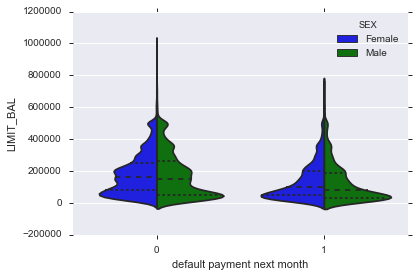

In [10]:
sns.violinplot(data=cc_data, x='default payment next month',y='LIMIT_BAL', hue='SEX', split=True, inner="quart")

### Verify the data quality

Why BILL_AMT1 Minimum-165580<br>
Why EDUCATION include 5 or 6<br>
Why Marriage include 0 zero<br>
Are there any zeros in the Past Payment fields (Pay_0_Sept...)

# Exceptional Work (10 points total)
* You have free reign to provide additional analyses.
*One idea: implement dimensionality reduction, then visualize and interpret the results.

feature creation ideas:
* Age brackets
* Ratio of Pay Amount to Bill Amount
* Ratio of Bill Amount to LIMIT_BAL
* Transformation of data - scaling

Sources:
https://www.wakari.io/sharing/bundle/ijstokes/pyvis-1h?has_login=False